In [2]:
import torch
#device = 'cuda:0'
device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

In [3]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [4]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [5]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [47]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.GaussNoise (p=0.2),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
           # [
             #   #albu.CLAHE(p=1),
            #    albu.RandomBrightness(p=1),
           #     albu.RandomGamma(p=1),
          #  ],
         #   p=0.9,
        #),

        #albu.OneOf(
            #[
             #   albu.Sharpen(p=1),
            #    albu.Blur(blur_limit=3, p=1),
           #     albu.MotionBlur(blur_limit=3, p=1),
          #  ],
         #   p=0.9,
        #),

        #albu.OneOf(
            #[
            #    albu.RandomContrast(p=1),
           #     albu.HueSaturationValue(p=1),
          #  ],
         #   p=0.9,
        #),
    ]
    return albu.Compose(train_transform)

In [70]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=None)

In [71]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [7]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [8]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight']
Y

device(type='cuda', index=1)

In [77]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"], downsampled_labels)
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [78]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze()

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [79]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = smp.losses.FocalLoss(mode="multiclass")
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:52<00:00,  1.91s/it]


Epoch: 1, Loss: 0.20344189722691813


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.052964 | F1-Score: 6.75% | IoU: 4.06% | Precision: 14.95% | Recall: 4.36% | Accuracy: 98.05%
Model saved at 1 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:04<00:00,  1.95s/it]


Epoch: 2, Loss: 0.04681429611819406


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.11it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.031758 | F1-Score: 12.25% | IoU: 8.69% | Precision: 44.46% | Recall: 10.65% | Accuracy: 98.33%
Model saved at 2 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:27<00:00,  2.02s/it]


Epoch: 3, Loss: 0.0327174793448179


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.11it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.025306 | F1-Score: 14.40% | IoU: 10.02% | Precision: 44.07% | Recall: 11.71% | Accuracy: 98.43%
Model saved at 3 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:25<00:00,  2.02s/it]


Epoch: 4, Loss: 0.026703074087779367


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:19<00:00,  1.12it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.022470 | F1-Score: 27.22% | IoU: 18.34% | Precision: 55.72% | Recall: 21.62% | Accuracy: 98.51%
Model saved at 4 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:36<00:00,  2.05s/it]


Epoch: 5, Loss: 0.02345076522399341


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:20<00:00,  1.11it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.021226 | F1-Score: 38.32% | IoU: 26.45% | Precision: 54.03% | Recall: 32.76% | Accuracy: 98.54%
Model saved at 5 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:54<00:00,  1.92s/it]


Epoch: 6, Loss: 0.02165325619580765


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.021112 | F1-Score: 41.98% | IoU: 29.33% | Precision: 53.17% | Recall: 37.29% | Accuracy: 98.53%
Model saved at 6 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:45<00:00,  1.89s/it]


Epoch: 7, Loss: 0.02032445291237485


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:17<00:00,  1.15it/s]


Validation: Loss: 0.019246 | F1-Score: 43.85% | IoU: 29.69% | Precision: 72.46% | Recall: 34.34% | Accuracy: 98.60%
Model saved at 7 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:46<00:00,  1.89s/it]


Epoch: 8, Loss: 0.019465195426657315


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.019012 | F1-Score: 52.48% | IoU: 37.03% | Precision: 67.59% | Recall: 46.73% | Accuracy: 98.60%
Model saved at 8 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:45<00:00,  1.89s/it]


Epoch: 9, Loss: 0.018751064910283013


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.018191 | F1-Score: 52.72% | IoU: 37.15% | Precision: 69.16% | Recall: 45.86% | Accuracy: 98.65%
Model saved at 9 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:46<00:00,  1.89s/it]


Epoch: 10, Loss: 0.018300623191340317


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.017827 | F1-Score: 56.54% | IoU: 40.09% | Precision: 69.25% | Recall: 49.14% | Accuracy: 98.67%
Model saved at 10 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:48<00:00,  1.90s/it]


Epoch: 11, Loss: 0.017777048712295872


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.017671 | F1-Score: 51.60% | IoU: 35.52% | Precision: 73.25% | Recall: 41.15% | Accuracy: 98.66%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 12, Loss: 0.017377991409551714


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.017260 | F1-Score: 57.55% | IoU: 40.78% | Precision: 70.52% | Recall: 49.13% | Accuracy: 98.68%
Model saved at 12 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:47<00:00,  1.89s/it]


Epoch: 13, Loss: 0.017057526742498722


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.017059 | F1-Score: 61.75% | IoU: 44.92% | Precision: 66.98% | Recall: 57.64% | Accuracy: 98.69%
Model saved at 13 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:47<00:00,  1.90s/it]


Epoch: 14, Loss: 0.016805263176079718


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:18<00:00,  1.13it/s]


Validation: Loss: 0.017126 | F1-Score: 62.02% | IoU: 45.26% | Precision: 68.10% | Recall: 57.48% | Accuracy: 98.70%
Model saved at 14 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:48<00:00,  1.90s/it]


Epoch: 15, Loss: 0.016421801416623978


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.016945 | F1-Score: 58.63% | IoU: 41.84% | Precision: 70.57% | Recall: 50.85% | Accuracy: 98.70%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:47<00:00,  1.89s/it]


Epoch: 16, Loss: 0.016095791778136647


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.016984 | F1-Score: 62.11% | IoU: 45.22% | Precision: 69.29% | Recall: 56.46% | Accuracy: 98.71%
Model saved at 16 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:50<00:00,  1.90s/it]


Epoch: 17, Loss: 0.015943332160672834


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017021 | F1-Score: 62.36% | IoU: 45.74% | Precision: 68.77% | Recall: 58.18% | Accuracy: 98.69%
Model saved at 17 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:50<00:00,  1.91s/it]


Epoch: 18, Loss: 0.015596331109202678


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.016660 | F1-Score: 64.14% | IoU: 47.40% | Precision: 66.38% | Recall: 62.46% | Accuracy: 98.72%
Model saved at 18 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 19, Loss: 0.015237089255524259


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.19it/s]


Validation: Loss: 0.017091 | F1-Score: 62.93% | IoU: 46.10% | Precision: 69.29% | Recall: 57.74% | Accuracy: 98.71%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:47<00:00,  1.89s/it]


Epoch: 20, Loss: 0.015138447927611489


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.016996 | F1-Score: 63.35% | IoU: 46.52% | Precision: 69.06% | Recall: 58.85% | Accuracy: 98.71%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:46<00:00,  1.89s/it]


Epoch: 21, Loss: 0.014837690650094902


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.017326 | F1-Score: 63.42% | IoU: 46.57% | Precision: 70.50% | Recall: 57.70% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 22, Loss: 0.014533971198984693


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.016697 | F1-Score: 65.00% | IoU: 48.36% | Precision: 68.28% | Recall: 62.36% | Accuracy: 98.73%
Model saved at 22 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:46<00:00,  1.89s/it]


Epoch: 23, Loss: 0.014378558727161539


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.016991 | F1-Score: 66.66% | IoU: 50.07% | Precision: 67.51% | Recall: 66.11% | Accuracy: 98.72%
Model saved at 23 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 24, Loss: 0.014042145670241406


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.20it/s]


Validation: Loss: 0.017186 | F1-Score: 65.67% | IoU: 49.02% | Precision: 68.67% | Recall: 63.02% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:48<00:00,  1.90s/it]


Epoch: 25, Loss: 0.013995994251942442


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.017003 | F1-Score: 66.01% | IoU: 49.41% | Precision: 69.05% | Recall: 63.35% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 26, Loss: 0.013824948178784501


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:16<00:00,  1.17it/s]


Validation: Loss: 0.016989 | F1-Score: 66.14% | IoU: 49.53% | Precision: 68.93% | Recall: 63.69% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:50<00:00,  1.90s/it]


Epoch: 27, Loss: 0.013476940136282674


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.18it/s]


Validation: Loss: 0.017093 | F1-Score: 65.97% | IoU: 49.35% | Precision: 69.99% | Recall: 62.69% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:48<00:00,  1.90s/it]


Epoch: 28, Loss: 0.013453101145944769


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:14<00:00,  1.19it/s]


Validation: Loss: 0.017349 | F1-Score: 63.63% | IoU: 46.96% | Precision: 71.78% | Recall: 57.87% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:49<00:00,  1.90s/it]


Epoch: 29, Loss: 0.01330774194831329


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:15<00:00,  1.17it/s]


Validation: Loss: 0.017314 | F1-Score: 65.33% | IoU: 48.63% | Precision: 70.34% | Recall: 61.04% | Accuracy: 98.75%


 37%|█████████████████████████████▋                                                  | 115/310 [03:41<06:16,  1.93s/it]


KeyboardInterrupt: 

In [9]:
best_model = torch.load('model-2023-12-28.pt')
best_model = best_model.to(device)

In [15]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.17it/s]


In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.721077,0.563815,0.727952,0.714330
2,0.659506,0.491987,0.647811,0.671631
3,0.692835,0.530029,0.702398,0.683529
4,0.675332,0.509812,0.635347,0.720687
5,0.629419,0.459235,0.662019,0.599880


In [17]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 67.56%
IoU: 51.10%
Precision: 67.51%
Recall: 67.80%
Overall Accuracy: 98.75%


In [18]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(r'Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

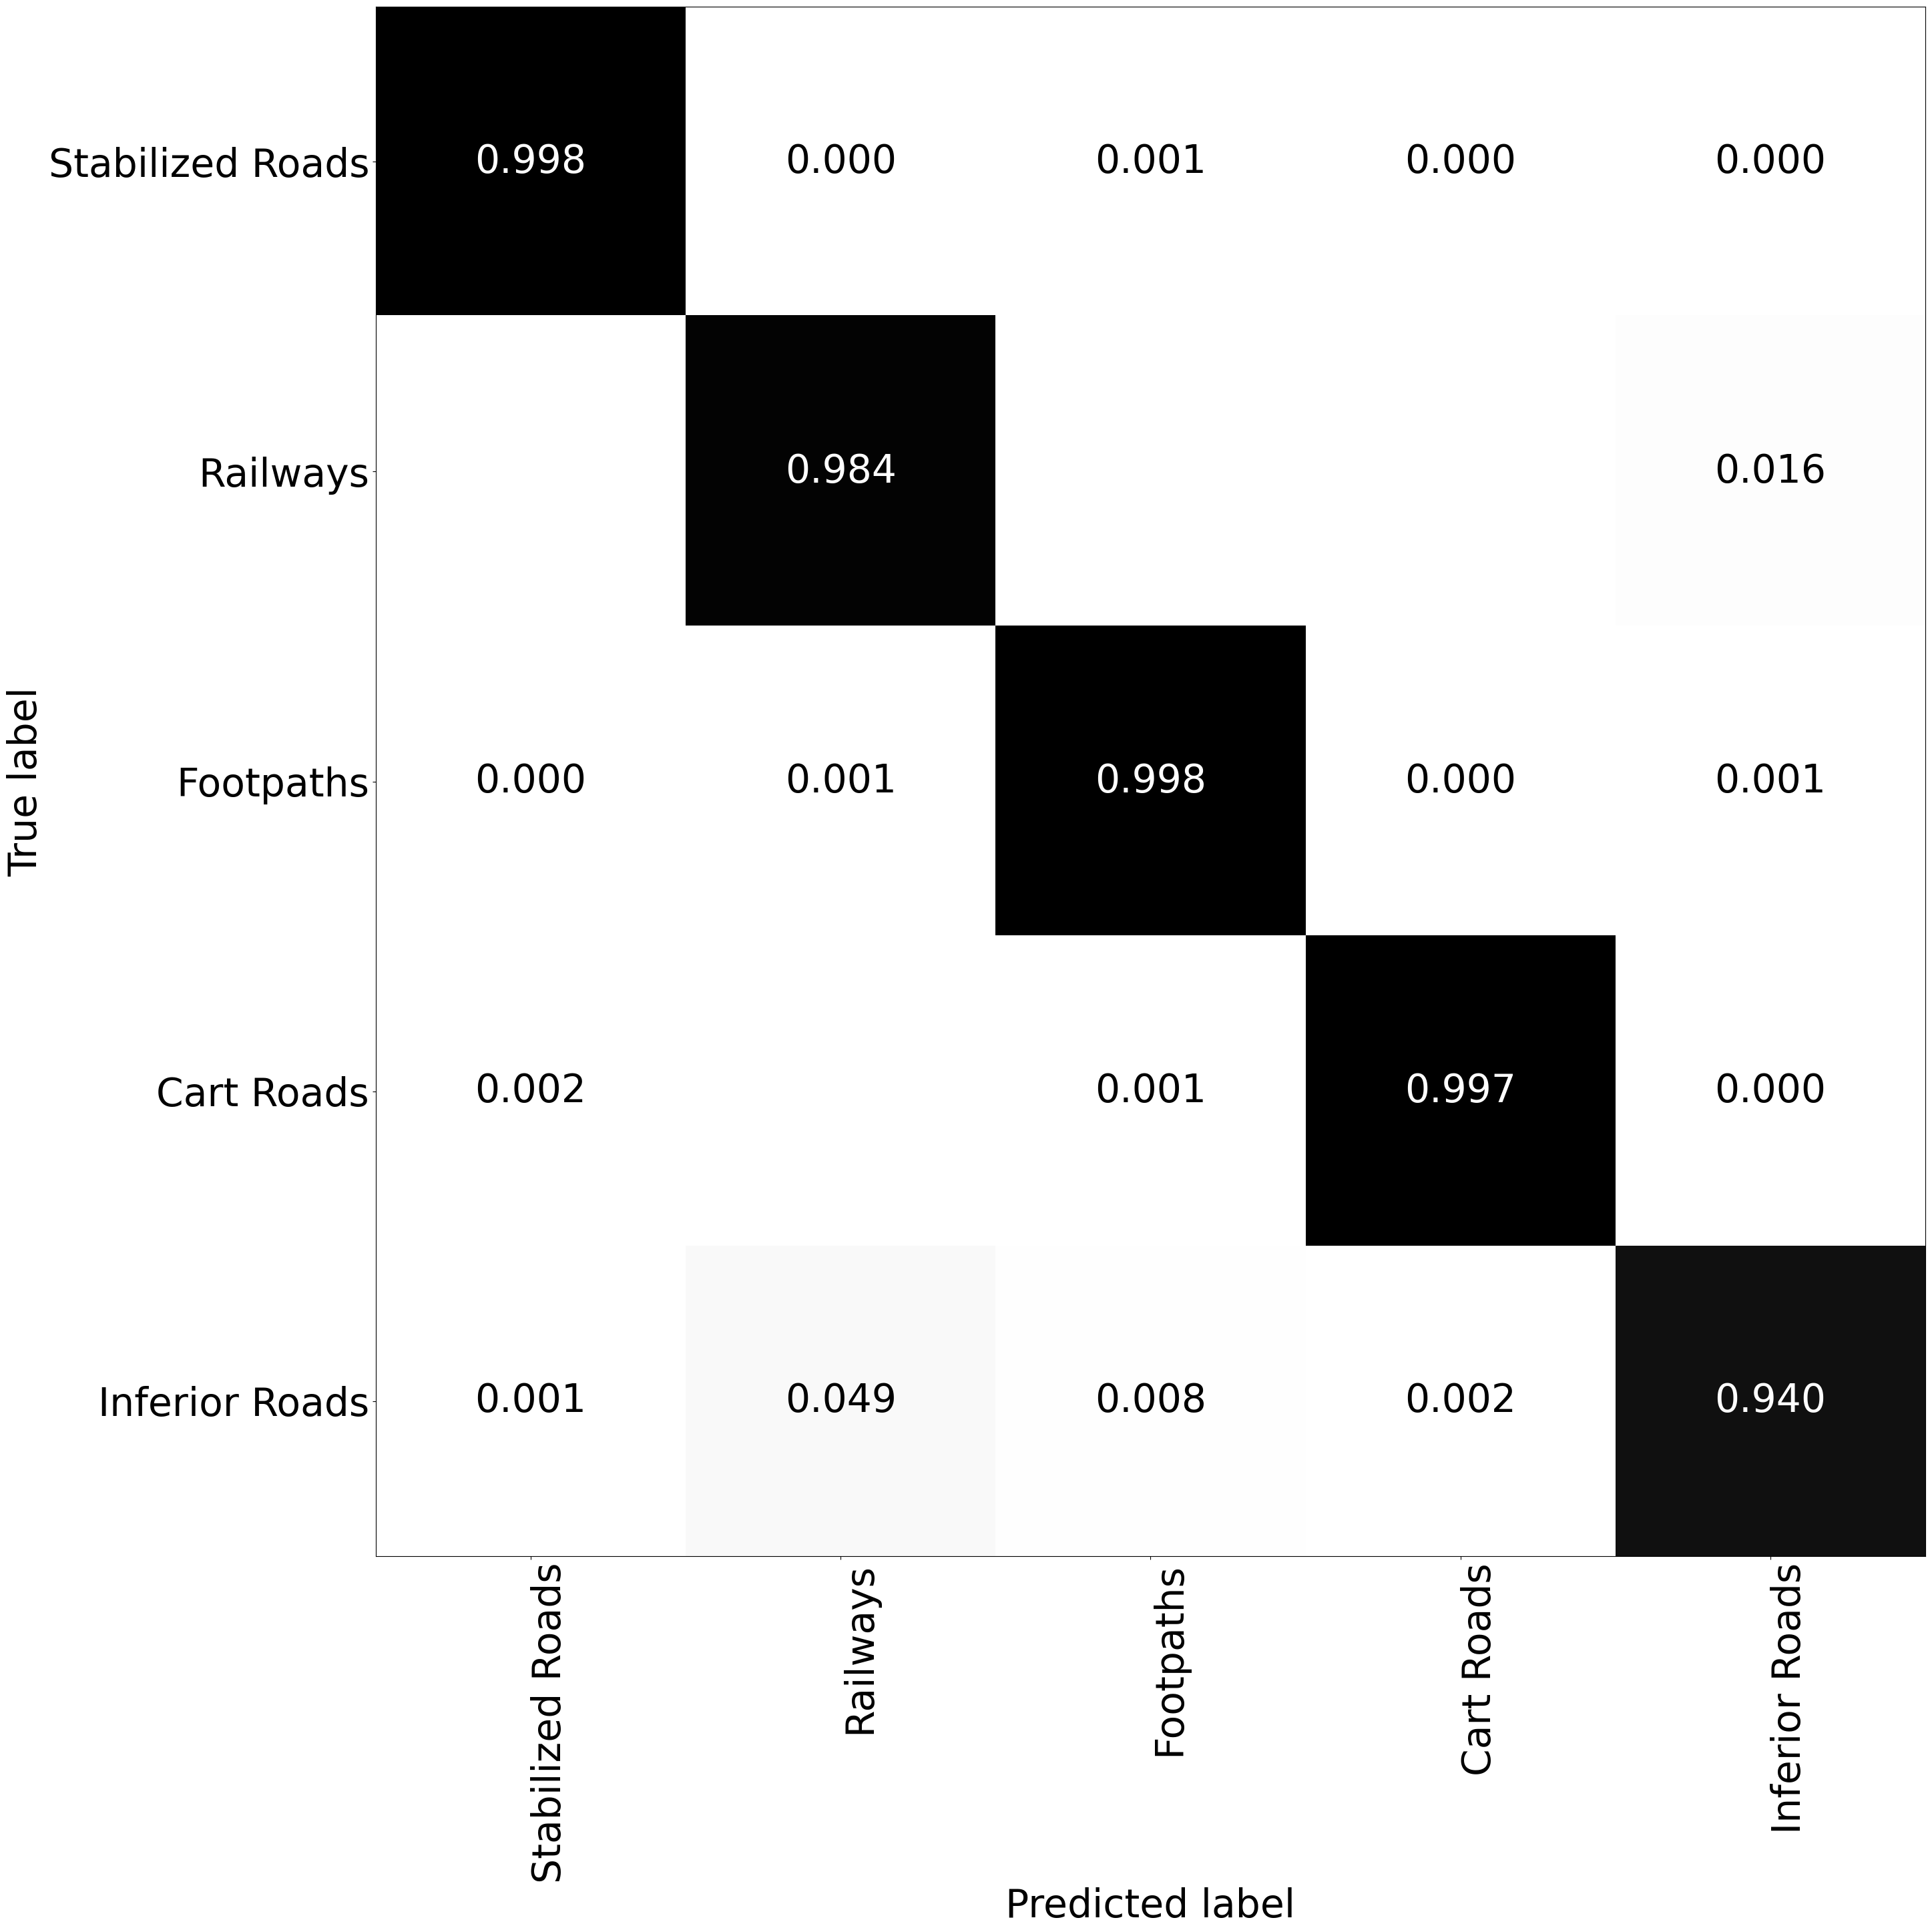

In [20]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [11]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


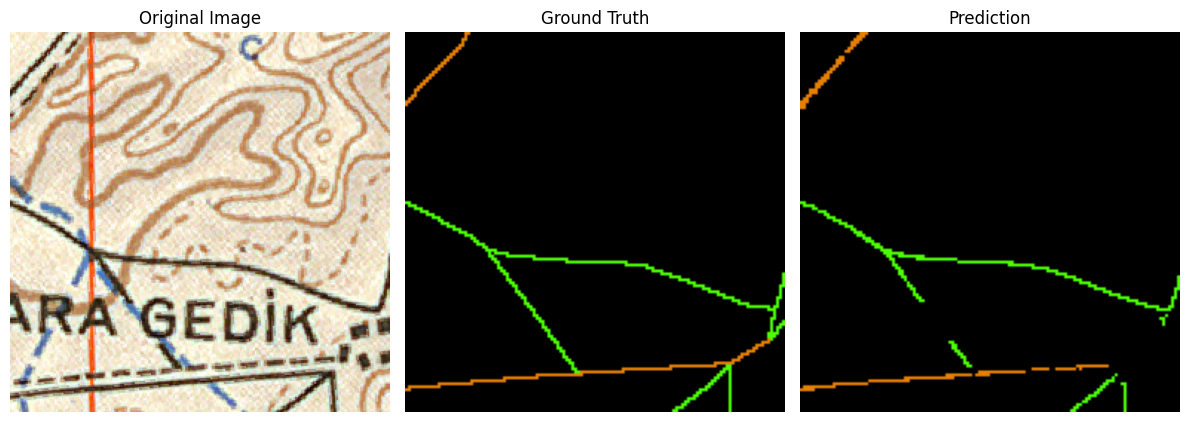

In [60]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = test_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
#torch.save(model, "model_test.pt")